# Tuning Parameters

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.grid_search import GridSearchCV  
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

In [2]:
# factorize or one hot code categorical columns
# complex factorize to make it so number for AA is after Z
def complex_factorize(df, feature):
    ser = pd.Series(df[feature].unique())
    func = lambda x: sorted(x.values.ravel())
    arr = np.hstack(ser.groupby(ser.str.len()).apply(func).values)
    return pd.factorize(arr)

def handle_cat_columns(dat, cat_handling='factorize'):
    new_dat = dat.copy()
    cat_features=[x for x in new_dat.select_dtypes(include=['O']).columns
                                     if x not in ['loss', 'id']]
    if cat_handling == 'factorize':
        print "complex factorizing categorical features"
        for feat in cat_features:
            val, ser = complex_factorize(new_dat, feat)
            new_dat[feat] = new_dat[feat].replace(ser, val)
    elif cat_handling == 'onehot':
        print "one hot coding categorical features"
        new_dat = pd.concat([new_dat, pd.get_dummies(new_dat, prefix=cat_features)],axis=1)
        new_dat = new_dat.drop(cat_features, 1)
    else:
        raise Exception('cat_handling Value Error')
    return new_dat

In [3]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='mae')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print "\nModel Report"
    print "MAE : %.4g" % mean_absolute_error(dtrain[target].values, dtrain_predictions)
    print "n_estimators: {}".format(alg.get_params()['n_estimators'])
             
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    fig, axs = plt.subplots(2, 1, figsize=(10,15))
    feat_imp[:30].plot(kind='bar', title='High Feature Importances', ax=axs[0])
    feat_imp[-30:].plot(kind='bar', title='Low Feature Importances', ax=axs[1])

In [4]:
train = pd.read_csv('../data/train-allstate.csv')
target = 'loss'
# log transform and add a shift to make the target symmetric and smoother
train[target] = np.log(train[target] + 200)
features = [x for x in train.columns if x not in ['id', 'loss']]
cat_features = [x for x in train.select_dtypes(include=['O']).columns if x not in ['id', 'loss']]
num_features = [x for x in train.select_dtypes(exclude=['O']).columns if x not in ['id', 'loss']]

In [5]:
train = handle_cat_columns(train)

complex factorizing categorical features



Model Report
MAE : 1106
n_estimators: 545


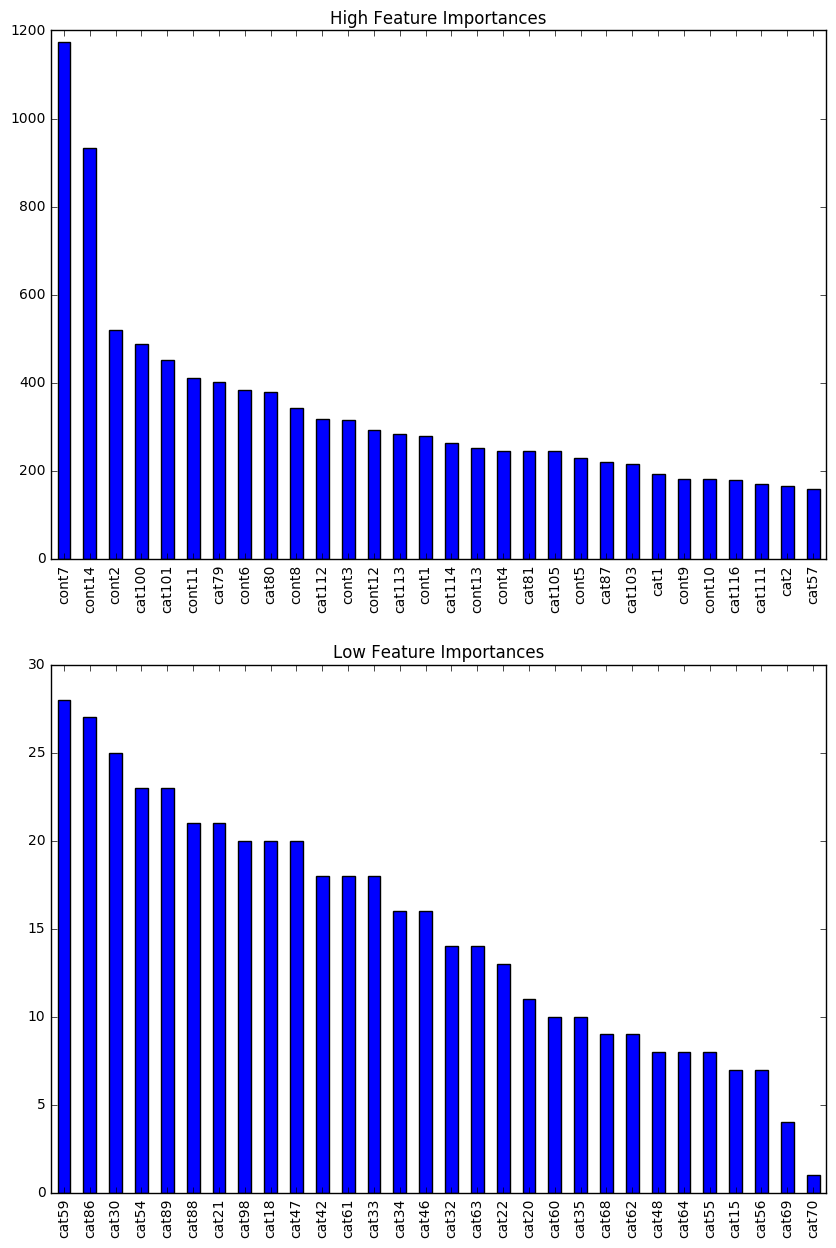

In [6]:
# find a fixed n_estimators for future tests
# 545
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 seed=27,
 silent=False)
modelfit(xgb1, train, features, target)

In [36]:
# max_depth and child_weight
param_test1 = {
 'max_depth':range(5,10,2),
 'min_child_weight':range(3,8,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=545, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', seed=27), 
 param_grid = param_test1, scoring='mean_absolute_error',iid=False, cv=5)
gsearch1.fit(train[features], train[target])
print 'Best Model: \n' 
print gsearch1.grid_scores_, "\n"
print gsearch1.best_params_, "\n"
print gsearch1.best_score_, "\n", "\n"

Best Model: 

[mean: -1184.23760, std: 6.28657, params: {'max_depth': 5, 'min_child_weight': 3}, mean: -1185.10040, std: 6.28521, params: {'max_depth': 5, 'min_child_weight': 5}, mean: -1184.95028, std: 6.66204, params: {'max_depth': 5, 'min_child_weight': 7}, mean: -1186.50351, std: 5.37767, params: {'max_depth': 7, 'min_child_weight': 3}, mean: -1185.17818, std: 5.87288, params: {'max_depth': 7, 'min_child_weight': 5}, mean: -1184.76674, std: 5.63092, params: {'max_depth': 7, 'min_child_weight': 7}, mean: -1196.70881, std: 6.59392, params: {'max_depth': 9, 'min_child_weight': 3}, mean: -1195.54127, std: 5.27697, params: {'max_depth': 9, 'min_child_weight': 5}, mean: -1193.85147, std: 6.11156, params: {'max_depth': 9, 'min_child_weight': 7}] 

{'max_depth': 5, 'min_child_weight': 3} 

-1184.23760058 




In [37]:
param_test2 = {
 'max_depth':[3, 4, 5, 6],
 'min_child_weight':[2, 3, 4]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=545, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', seed=27), 
 param_grid = param_test2, scoring='mean_absolute_error',iid=False, cv=5)
gsearch2.fit(train[features], train[target])
print 'Best Model: \n' 
print gsearch2.grid_scores_, "\n"
print gsearch2.best_params_, "\n"
print gsearch2.best_score_, "\n", "\n"

KeyboardInterrupt: 

In [34]:
# potential automated tuning function
def tune_params(train, features, target,
                to_tune, init_tune_params,
                other_params,
                depth=2, factor=3.0, spacing=1.0, num_2_check = 3.0,
                score_func='mean_absolute_error'):
    i=0
    num_2_tune = len(to_tune)
    params = init_tune_params
    best={}
    for j in range(num_2_tune):
        best[to_tune[j]] = params[to_tune[j]]
    
    while i < depth:
        check_range = []
        for j in range(int(num_2_check)):
            check_range.append(((1.0-(num_2_check))*spacing/2.0) + spacing*j)
        for j in range(num_2_tune):
            params[to_tune[j]] = [best[to_tune[j]] + x for x in check_range]
            if to_tune[j] in set(['max_depth']):
                params[to_tune[j]] = [int(x) for x in params[to_tune[j]]]

        print 'Checking', params, '\n'
        gsearch = GridSearchCV(estimator = XGBRegressor(learning_rate =other_params['learning_rate'],
                                                        n_estimators=other_params['n_estimators'],
                                                        max_depth=other_params['max_depth'],
                                                        min_child_weight=other_params['min_child_weight'],
                                                        gamma=other_params['gamma'], 
                                                        subsample=other_params['subsample'],
                                                        colsample_bytree=other_params['colsample_bytree'],
                                                        objective= other_params['objective'],
                                                        seed=other_params['seed']),
                               param_grid = params,
                               scoring=score_func,
                               iid=False, cv=5)
        gsearch.fit(train[features], train[target])
        print 'Best Model: \n' 
        print gsearch.grid_scores_, "\n"
        print gsearch.best_params_, "\n"
        print gsearch.best_score_, "\n", "\n"
        for j in range(num_2_tune):
            best[to_tune[j]] = gsearch.best_params_[to_tune[j]]
        i+=1
        spacing = spacing / factor

In [35]:
test_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5.0,
    'gamma': 0.0,
    'n_estimators': 545,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'seed': 27
}

int_tune_params = {
    'max_depth': 5,
    'min_child_weight': 5.0
}
tune_params(train[:100], features, target,
            ['max_depth', 'min_child_weight'], int_tune_params, test_params)

Checking {'max_depth': [4, 5, 6], 'min_child_weight': [4.0, 5.0, 6.0]} 

Best Model: 

[mean: -2002.71313, std: 565.79928, params: {'max_depth': 4, 'min_child_weight': 4.0}, mean: -2093.84616, std: 576.05309, params: {'max_depth': 4, 'min_child_weight': 5.0}, mean: -2153.00059, std: 607.35134, params: {'max_depth': 4, 'min_child_weight': 6.0}, mean: -1950.50113, std: 587.37401, params: {'max_depth': 5, 'min_child_weight': 4.0}, mean: -2035.46719, std: 595.33651, params: {'max_depth': 5, 'min_child_weight': 5.0}, mean: -2183.36529, std: 546.72782, params: {'max_depth': 5, 'min_child_weight': 6.0}, mean: -1938.93410, std: 569.22558, params: {'max_depth': 6, 'min_child_weight': 4.0}, mean: -1979.68123, std: 670.27076, params: {'max_depth': 6, 'min_child_weight': 5.0}, mean: -2154.43989, std: 497.29256, params: {'max_depth': 6, 'min_child_weight': 6.0}] 

{'max_depth': 6, 'min_child_weight': 4.0} 

-1938.93409502 


Checking {'max_depth': [5, 6, 6], 'min_child_weight': [3.6666666666666665,

[0]